To set up the environment:

```
conda create -n cuda_test2 python=3
conda activate cuda_test2
conda install numba, cudatoolkit, ipykernel, matplotlib
python -m ipykernel install --user --name cuda_tests2 --display-name "Numba Tests"
```

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import timeit

from numba import jit, cuda

## Helper Functions

We create a series of helper functions to generate and visualize the data.

In [2]:
def create_stack(num_times, height, width):
    """Create a stack of random images as a numpy array.

    Parameters
    ----------
    num_times : `int`
        The number of times
    height : `int`
        The height of each image
    width : `int`
        The width of each image

    Returns
    -------
    `numpy.ndarray`
        A shape (num_times, height, width) array with noisy data.
    """
    return np.random.rand(num_times, height, width)

@jit
def insert_object(stack, times, y, x, vy, vx, flux):
    """Insert a fake object with a given linear motion in pixel space
    into a stack of images.
    """
    for i, t in enumerate(times):
        py = int(y + vy * t)
        px = int(x + vx * t)
        if py >= 0 and px >= 0 and py < stack.shape[1] and px < stack.shape[2]:
            stack[i][py][px] += flux
        
def plot_stack(stack):
    num_images = stack.shape[0]
    num_cols = 5
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols)
    for i in range(num_rows):
        for j in range(num_cols):
            ind = num_cols * i + j
            if ind < num_images:
                axs[i, j].imshow(stack[ind], cmap="gray")

We start by creating a stack of images with just noisy background.

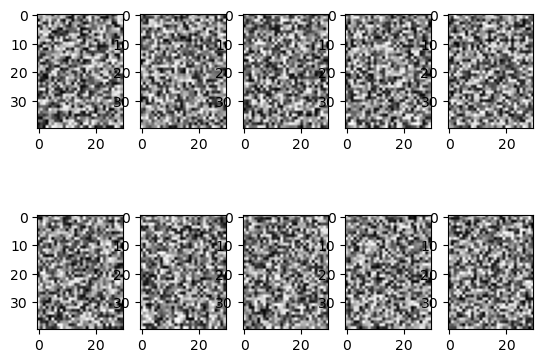

In [3]:
# Create images with no object
num_times = 10
height = 40
width = 30
fake_data = create_stack(num_times, height, width)
plot_stack(fake_data)

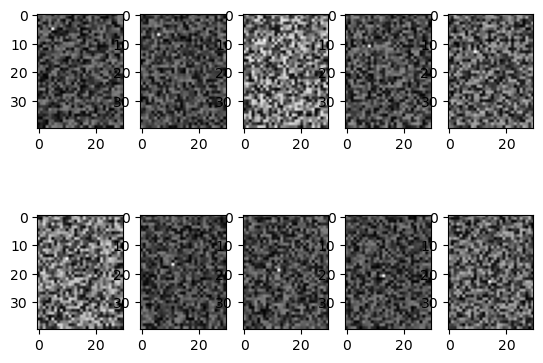

In [4]:
# Insert a fake object
times = np.array([i for i in range(num_times)])
insert_object(fake_data, times, 5, 5, 2, 1, 1.0)
plot_stack(fake_data)

In [5]:
@cuda.jit
def gpu_shift_and_stack(images, times, vy, vx, result):
    r, c = cuda.grid(2)
    if r < result.shape[0] and c < result.shape[1]:
        total = 0.0
        for i in range(times.shape[0]):
            py = r + vy * times[i]
            px = c + vx * times[i]
            if py >= 0 and px >= 0 and py < images.shape[1] and px < images.shape[2]:
                total += images[i][py][px]
        result[r][c] = total

def shift_and_stack(images, times, vx, vy):
    height = images.shape[1]
    width = images.shape[2]
    results = np.zeros((height, width))

    threadsperblock = (16, 16)
    blockspergrid = (
        math.ceil(height / threadsperblock[0]),
        math.ceil(width / threadsperblock[1])
    )
    gpu_shift_and_stack[blockspergrid, threadsperblock](images, times, vx, vy, results)
    
    return results
    

/astro/users/jkubica/miniconda3/envs/cuda_test2/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 6 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/astro/users/jkubica/miniconda3/envs/cuda_test2/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


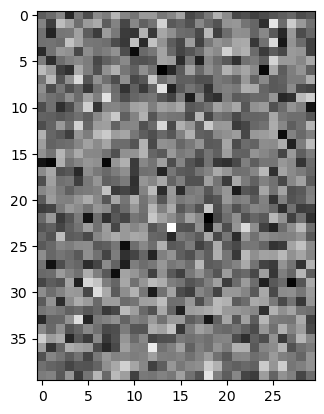

In [6]:
result_none = shift_and_stack(fake_data, times, 0, 0)
plt.imshow(result_none, cmap="gray")

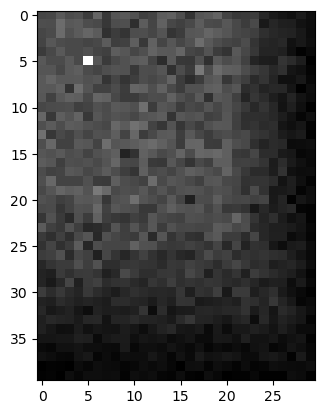

In [7]:
# Things look good when we line them up on the correct velocity
result_none = shift_and_stack(fake_data, times, 2, 1)
plt.imshow(result_none, cmap="gray")

In [8]:
%%timeit
result_none = shift_and_stack(fake_data, times, 2, 1)

610 µs ± 867 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We pay a cost for transfering the image stack to/from the GPU during each function call. Instead we can move the numpy arrays there once and reuse them.

In [9]:
# Transfer the stack to the device
device_images = cuda.to_device(fake_data)
device_times = cuda.to_device(times)

In [10]:
%%timeit
result_none = shift_and_stack(device_images, device_times, 2, 1)

226 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
